In [1]:
""" use smaller learning rate for gradient descent or increase batch size """

import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import time 
import numpy as np
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.compat.v1.disable_eager_execution() 
import tensorflow_probability as tfp
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import matplotlib.pyplot as plt

from data_loader import load_data
from data_preprocesser import preprocess_data
from maf import MAF 
from experiment import Experiment

Data successfully loaded...

Data successfully preprocessed...

TensorFlow version: 2.5.0
Number of dimensions: 37
Learning rate: 0.0001

Successfully created model...

Optimizer: Adam_2
Optimizer and loss successfully defined...

Iteration 0: 52.72296142578125
Iteration 10000: -12.123727798461914
Iteration 20000: -31.257366180419922
Iteration 30000: -19.52370834350586
Iteration 40000: -34.72262954711914
Iteration 50000: -37.22956085205078
Iteration 60000: -31.837202072143555
Iteration 70000: -36.162353515625
Iteration 80000: -40.44646453857422
Iteration 90000: -39.50082015991211

Training completed...
Training time: 508.4956090450287 seconds
Training finished...

Displaying results...


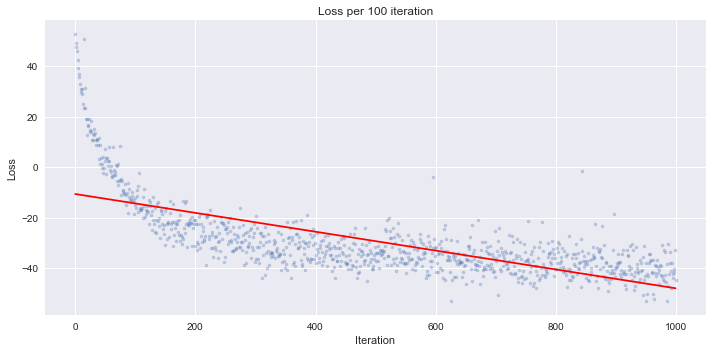

Optimizer: RMSProp
Optimizer and loss successfully defined...

Iteration 0: 52.72296142578125
Iteration 10000: -8.40821361541748
Iteration 20000: -24.88846778869629
Iteration 30000: -13.85255241394043
Iteration 40000: -30.42304229736328
Iteration 50000: -33.980743408203125
Iteration 60000: -26.754453659057617
Iteration 70000: -35.094207763671875
Iteration 80000: -34.587615966796875
Iteration 90000: -27.752574920654297

Training completed...
Training time: 565.5382442474365 seconds
Training finished...

Displaying results...


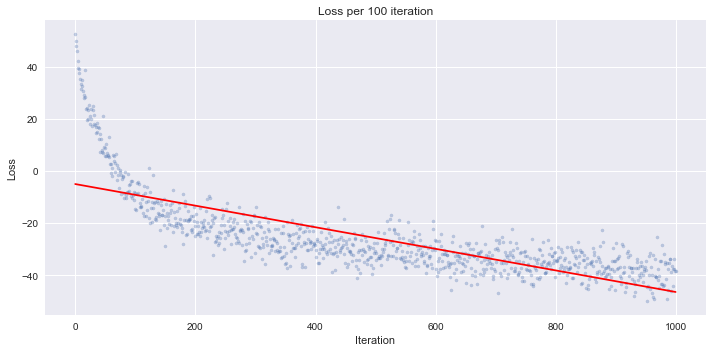

Optimizer: GradientDescent
Optimizer and loss successfully defined...

Iteration 0: 52.72296142578125
Iteration 10000: 31.858509063720703
Iteration 20000: 14.227487564086914
Iteration 30000: 5.67965841293335
Iteration 40000: -4.409252643585205
Iteration 50000: nan
Iteration 60000: nan
Iteration 70000: nan
Iteration 80000: nan
Iteration 90000: nan

Training completed...
Training time: 490.9801027774811 seconds
Training finished...

Displaying results...


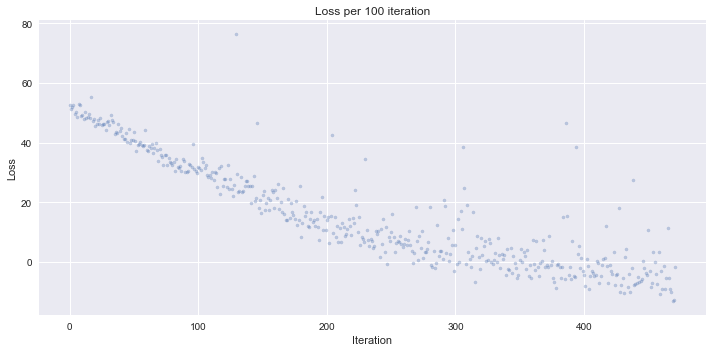

In [4]:
def train(session, loss, optimizer, steps=int(1e5)):
    
    """ optimize for all dimensions """
    
    start_time = time.time()
    
    recorded_steps = []
    recorded_losses = []
    for i in range(steps):
        _, loss_per_iteration = session.run([optimizer, loss])
        if i % 100 == 0:
            recorded_steps.append(i)
            recorded_losses.append(loss_per_iteration)
        if i % int(1e4) == 0:
            print('Iteration {iteration}: {loss}'.format(iteration=i,loss=loss_per_iteration))
    print('\nTraining completed...')
    print(f'Training time: {time.time() - start_time} seconds')
    return recorded_losses


def plot_results(recorded_losses):
    
    """ plot loss """
    print('Displaying results...')
    fig = plt.figure(figsize=(10,5))
    x = np.arange(len(recorded_losses))
    y = recorded_losses
    m, b = np.polyfit(x, y, 1) 
    plt.scatter(x, y, s=10, alpha=0.3)
    plt.plot(x, m*x+b, c="r")
    plt.title('Loss per 100 iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

def main():
    
    """ load data """

    filename = 'prostate.xls'
    directory = '/Users/kaanguney.keklikci/Data/'

    loader = load_data(filename, directory)
    loader.create_directory(directory)
    data = loader.read_data(directory, filename)
    print('Data successfully loaded...\n')
    
    """ preprocess data """

    fillna_vals = ['sz', 'sg', 'wt']
    dropna_vals = ['ekg', 'age']
    drop_vals = ['patno', 'sdate']

    preprocesser = preprocess_data(StandardScaler(), fillna_vals, dropna_vals, drop_vals)
    data = preprocesser.dropna_features(data)
    data = preprocesser.impute(data)
    data = preprocesser.drop_features(data)
    data = preprocesser.encode_categorical(data)
    data = preprocesser.scale(data)
    print('Data successfully preprocessed...\n')
    
    """ set MAF parameters """

    batch_size = 32
    dtype = np.float32
    tf_version = tf.__version__
    params = 2
    hidden_units = [512,512]
    base_dist = tfp.distributions.Normal(loc=0., scale=1., name="gaussian")
    dims = data.shape[1]
    learning_rate = 1e-4
    steps = 1e4

    """ initialize samples """

    maf = MAF(dtype, tf_version, batch_size, params, hidden_units, base_dist, dims)

    dims = maf.get_dims(data)
    samples = maf.create_tensor(data)
    print(f'TensorFlow version: {maf.tf_version}')
    print(f'Number of dimensions: {maf.dims}')
    print(f'Learning rate: {learning_rate}\n')
    
    """ initialize MAF """

    maf = maf.make_maf(data)
    print('Successfully created model...\n')
    
    """ initialize loss and optimizer """

    loss = -tf.reduce_mean(maf.log_prob(samples))
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss)
    
    experiment = Experiment(optimizer, learning_rate, loss, steps)
    
    keywords = ['adam', 'rmsprop', 'sgd']
    
    for keyword in keywords:
    
        session = tf.compat.v1.Session()
        tf.compat.v1.set_random_seed(42)
        experiment.change_optimizer(learning_rate, loss, keyword=keyword)
        optimizer = experiment.get_optimizer()
        session.run(tf.compat.v1.global_variables_initializer())
        print(f'Optimizer: {optimizer.name}')
        print('Optimizer and loss successfully defined...\n')

        """ start training """
        recorded_losses = train(session, loss, optimizer)
        print('Training finished...\n')

        """ display results """
        plot_results(recorded_losses)
    
    
if __name__ == "__main__":
    main()